In [12]:
import pandas as pd
import sqlite3
import pathlib
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# For local imports, temporarily add project root to Python sys.path

#PROJECT_ROOT = pathlib.Path(__file__).resolve().parent.parent
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from utils.logger import logger  # noqa: E402

# Constants
DW_DIR: pathlib.Path = pathlib.Path("data").joinpath("dw")
DB_PATH = pathlib.Path("C:/Projects/smart-store-derekfintel/data/dw/smart_sales.db")
#DB_PATH: pathlib.Path = DW_DIR.joinpath("smart_sales.db")
OLAP_OUTPUT_DIR: pathlib.Path = pathlib.Path("data").joinpath("olap_cubing_outputs")

# Create output directory if it does not exist
OLAP_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def ingest_sales_data_from_dw() -> pd.DataFrame:
    """Ingest sales data from SQLite data warehouse."""
    try:
        conn = sqlite3.connect(DB_PATH)
        sales_df = pd.read_sql_query("SELECT * FROM sale", conn)
        conn.close()
        logger.info("Sales data successfully loaded from SQLite data warehouse.")
        return sales_df
    except Exception as e:
        logger.error(f"Error loading sale table data from data warehouse: {e}")
        raise

def ingest_customer_data_from_dw() -> pd.DataFrame:
    """Ingest customer data from SQLite data warehouse."""
    try:
        conn = sqlite3.connect(DB_PATH)
        customer_df = pd.read_sql_query("SELECT * FROM customer", conn)
        conn.close()
        logger.info("Customer data successfully loaded from SQLite data warehouse.")
        return customer_df
    except Exception as e:
        logger.error(f"Error loading customer table data from data warehouse: {e}")
        raise


def create_olap_cube(
    sales_df: pd.DataFrame, dimensions: list, metrics: dict
) -> pd.DataFrame:
    """
    Create an OLAP cube by aggregating data across multiple dimensions.

    Args:
        sales_df (pd.DataFrame): The sales data.
        dimensions (list): List of column names to group by.
        metrics (dict): Dictionary of aggregation functions for metrics.

    Returns:
        pd.DataFrame: The multidimensional OLAP cube.
    """
    try:
        # Group by the specified dimensions and aggregate metrics
        # When we use the groupby() method in Pandas, 
        # it creates a hierarchical index (also known as a MultiIndex) for the grouped data. 
        # This structure reflects the grouping levels but can make the resulting DataFrame 
        # harder to interact with, especially for tasks like slicing, querying, or merging data. 
        # Converting the hierarchical index into a flat table by calling reset_index()
        # simplifies our operations.

        # NOTE: Pandas generates hierarchical column names when we specify 
        # multiple aggregation functions for a single column. 
        # If we specify only one aggregation function per column, 
        # the resulting column names will not include the suffix.

        # Group by the specified dimensions
        grouped = sales_df.groupby(dimensions)

        # Perform the aggregations
        cube = grouped.agg(metrics).reset_index()

        # Add a list of sale IDs for traceability
        cube["transaction_id"] = grouped["transaction_id"].apply(list).reset_index(drop=True)

        # Generate explicit column names
        explicit_columns = generate_column_names(dimensions, metrics)
        explicit_columns.append("transaction_id")  # Include the traceability column
        explicit_columns = [
        'DayOfWeek',
        'product_id',
        'customer_id',
        'region',
        'sale_amount_sum',
        'sale_amount_mean',
        'transaction_id_count',
        'transaction_id'
        ]

        print("cube.columns:", cube.columns.tolist())
        print("explicit_columns:", explicit_columns)
        print("len(cube.columns):", len(cube.columns))
        print("len(explicit_columns):", len(explicit_columns))

        cube.columns = explicit_columns

        logger.info(f"OLAP cube created with dimensions: {dimensions}")
        return cube
    except Exception as e:
        logger.error(f"Error creating OLAP cube: {e}")
        raise

def generate_column_names(dimensions: list, metrics: dict) -> list:
    """
    Generate explicit column names for OLAP cube, ensuring no trailing underscores.
    
    Args:
        dimensions (list): List of dimension columns.
        metrics (dict): Dictionary of metrics with aggregation functions.
        
    Returns:
        list: Explicit column names.
    """
    # Start with dimensions
    column_names = dimensions.copy()
    
    # Add metrics with their aggregation suffixes
    for column, agg_funcs in metrics.items():
        if isinstance(agg_funcs, list):
            for func in agg_funcs:
                column_names.append(f"{column}_{func}")
        else:
            column_names.append(f"{column}_{agg_funcs}")
    
    # Remove trailing underscores from all column names
    column_names = [col.rstrip("_") for col in column_names]
    
    return column_names
    

def write_cube_to_csv(cube: pd.DataFrame, filename: str) -> None:
    """Write the OLAP cube to a CSV file."""
    try:
        output_path = OLAP_OUTPUT_DIR.joinpath(filename)
        cube.to_csv(output_path, index=False)
        logger.info(f"OLAP cube saved to {output_path}.")
    except Exception as e:
        logger.error(f"Error saving OLAP cube to CSV file: {e}")
        raise

def main():
    """Main function for OLAP cubing."""
    logger.info("Starting OLAP Cubing process...")

    # Step 1: Ingest data
    sales_df = ingest_sales_data_from_dw()
    customer_df = ingest_customer_data_from_dw()

    # Step 2: Enrich sales data with customer info
    sales_df = sales_df.merge(customer_df, on="customer_id", how="left")

    # Step 3: Add time-based dimensions
    sales_df["sale_date"] = pd.to_datetime(sales_df["sale_date"])
    sales_df["DayOfWeek"] = sales_df["sale_date"].dt.day_name()
    sales_df["Month"] = sales_df["sale_date"].dt.month
    sales_df["Year"] = sales_df["sale_date"].dt.year

    # Step 4: Define cube structure
    dimensions = ["DayOfWeek", "product_id", "customer_id", "region"]
    metrics = {
        "sale_amount": ["sum", "mean"],
        "transaction_id": "count",
        "region": "count",
    }

    # Step 5: Create cube
    olap_cube = create_olap_cube(sales_df, dimensions, metrics)

    # Step 6: Output cube
    write_cube_to_csv(olap_cube, "multidimensional_olap_cube.csv")

    logger.info("OLAP Cubing process completed successfully.")
    logger.info(f"Please see outputs in {OLAP_OUTPUT_DIR}")

if __name__ == "__main__":
    main()

2025-04-17 22:13:14.710 | INFO     | __main__:main:149 - Starting OLAP Cubing process...
2025-04-17 22:13:14.717 | INFO     | __main__:ingest_sales_data_from_dw:26 - Sales data successfully loaded from SQLite data warehouse.
2025-04-17 22:13:14.720 | INFO     | __main__:ingest_customer_data_from_dw:38 - Customer data successfully loaded from SQLite data warehouse.
2025-04-17 22:13:14.736 | INFO     | __main__:create_olap_cube:103 - OLAP cube created with dimensions: ['DayOfWeek', 'product_id', 'customer_id', 'region']
2025-04-17 22:13:14.739 | INFO     | __main__:write_cube_to_csv:142 - OLAP cube saved to data\olap_cubing_outputs\multidimensional_olap_cube.csv.
2025-04-17 22:13:14.741 | INFO     | __main__:main:178 - OLAP Cubing process completed successfully.
2025-04-17 22:13:14.742 | INFO     | __main__:main:179 - Please see outputs in data\olap_cubing_outputs


cube.columns: [('DayOfWeek', ''), ('product_id', ''), ('customer_id', ''), ('region', ''), ('sale_amount', 'sum'), ('sale_amount', 'mean'), ('transaction_id', 'count'), ('region', 'count')]
explicit_columns: ['DayOfWeek', 'product_id', 'customer_id', 'region', 'sale_amount_sum', 'sale_amount_mean', 'transaction_id_count', 'transaction_id']
len(cube.columns): 8
len(explicit_columns): 8


2025-04-17 22:13:14.772 | INFO     | __main__:main:172 - Starting SALES_LOW_REVENUE_DAYOFWEEK analysis...
2025-04-17 22:13:14.778 | INFO     | __main__:load_olap_cube:18 - OLAP cube data successfully loaded from data\olap_cubing_outputs\multidimensional_olap_cube.csv.
2025-04-17 22:13:14.805 | INFO     | __main__:analyze_sales_by_weekday:32 - Sales aggregated by DayOfWeek successfully.
2025-04-17 22:13:14.814 | INFO     | __main__:identify_least_profitable_day:57 - Least profitable day: Friday with revenue $8617.76.
2025-04-17 22:13:14.816 | INFO     | __main__:main:178 - Least profitable day: Friday
2025-04-17 22:13:14.963 | INFO     | __main__:visualize_sales_by_weekday:82 - Visualization saved to data\results\sales_by_day_of_week.png.


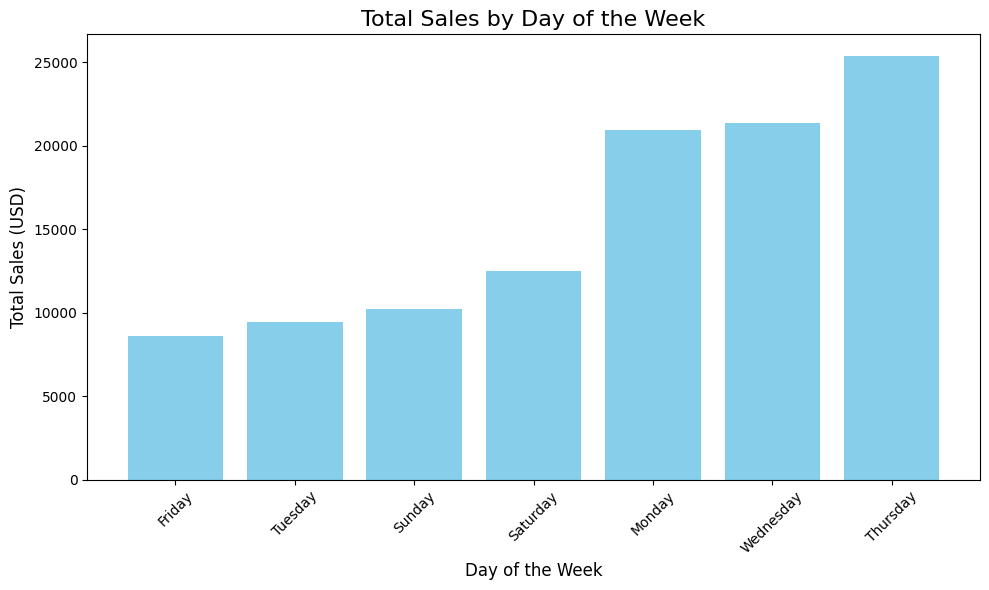

2025-04-17 22:13:15.045 | INFO     | __main__:analyze_sales_by_day_and_region:47 - Sales aggregated by DayOfWeek and Region successfully.
2025-04-17 22:13:15.250 | INFO     | __main__:visualize_sales_by_day_and_region:104 - Stacked region-by-day chart saved to data\results\sales_by_day_and_region_stacked.png.


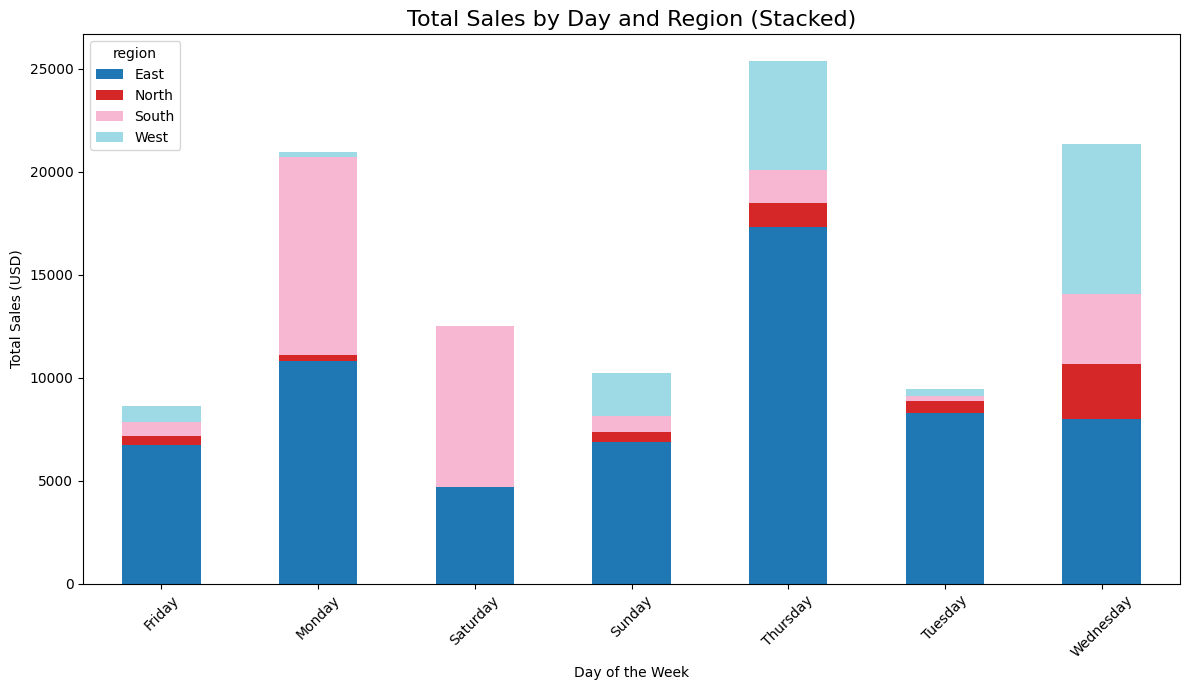

2025-04-17 22:13:15.582 | INFO     | __main__:visualize_region_heatmap:126 - Heatmap saved to data\results\sales_heatmap_by_region_and_day.png.


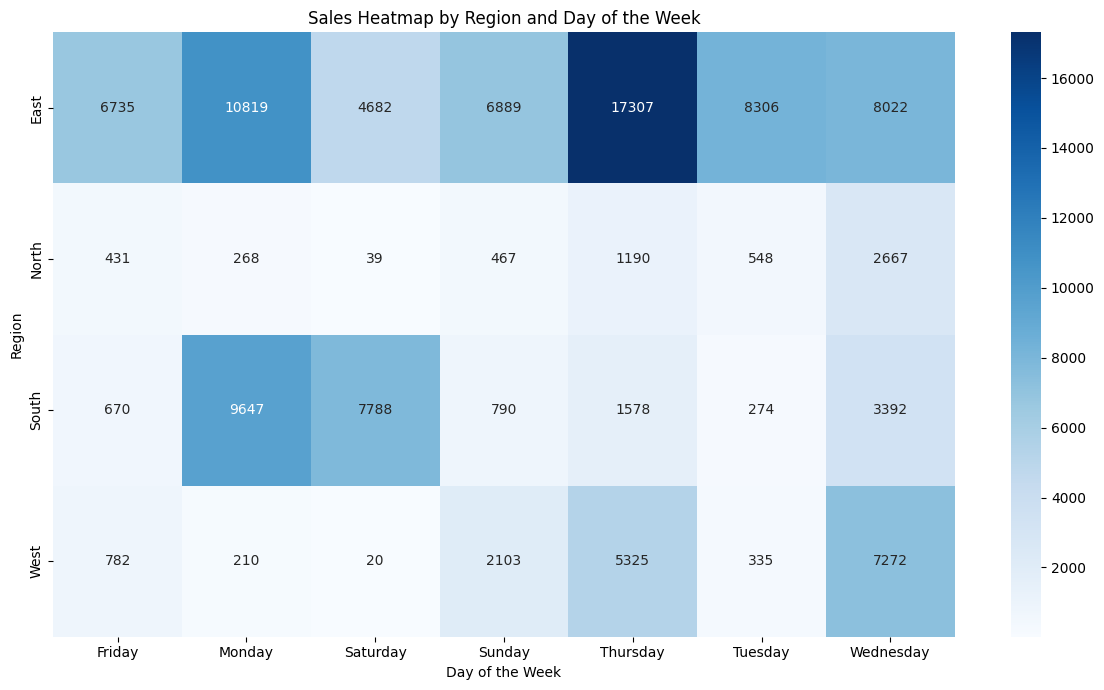

2025-04-17 22:13:15.698 | INFO     | __main__:generate_statistical_insights:135 - Sales by Day of Week - Summary Statistics:
2025-04-17 22:13:15.700 | INFO     | __main__:generate_statistical_insights:136 - 
count        7.000000
mean     15508.048571
std       6856.847357
min       8617.760000
25%       9856.510000
50%      12528.520000
75%      21149.030000
max      25398.980000
Name: TotalSales, dtype: float64
2025-04-17 22:13:15.702 | INFO     | __main__:generate_statistical_insights:146 - High-performing days (Z > 1): ['Thursday']
2025-04-17 22:13:15.703 | INFO     | __main__:generate_statistical_insights:147 - Low-performing days (Z < -1): ['Friday']
2025-04-17 22:13:15.704 | INFO     | __main__:generate_statistical_insights:151 - Coefficient of Variation in weekday sales: 0.44
2025-04-17 22:13:15.709 | INFO     | __main__:generate_statistical_insights:162 - Most consistent region: North (StdDev = 895.45)
2025-04-17 22:13:15.710 | INFO     | __main__:main:188 - Full analysis and 

In [ ]:
# For local imports
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from utils.logger import logger  # noqa: E402

# Constants
OLAP_OUTPUT_DIR: pathlib.Path = pathlib.Path("data").joinpath("olap_cubing_outputs")
CUBED_FILE: pathlib.Path = OLAP_OUTPUT_DIR.joinpath("multidimensional_olap_cube.csv")
RESULTS_OUTPUT_DIR: pathlib.Path = pathlib.Path("data").joinpath("results")
RESULTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def load_olap_cube(file_path: pathlib.Path) -> pd.DataFrame:
    try:
        cube_df = pd.read_csv(file_path)
        logger.info(f"OLAP cube data successfully loaded from {file_path}.")
        return cube_df
    except Exception as e:
        logger.error(f"Error loading OLAP cube data: {e}")
        raise


def analyze_sales_by_weekday(cube_df: pd.DataFrame) -> pd.DataFrame:
    try:
        sales_by_weekday = (
            cube_df.groupby("DayOfWeek")["sale_amount_sum"].sum().reset_index()
        )
        sales_by_weekday.rename(columns={"sale_amount_sum": "TotalSales"}, inplace=True)
        sales_by_weekday.sort_values(by="TotalSales", inplace=True)
        logger.info("Sales aggregated by DayOfWeek successfully.")
        return sales_by_weekday
    except Exception as e:
        logger.error(f"Error analyzing sales by DayOfWeek: {e}")
        raise


# Analyze sales by DayOfWeek and Region
def analyze_sales_by_day_and_region(cube_df: pd.DataFrame) -> pd.DataFrame:
    try:
        region_day_sales = (
            cube_df.groupby(["DayOfWeek", "region"])["sale_amount_sum"]
            .sum()
            .reset_index()
        )
        logger.info("Sales aggregated by DayOfWeek and Region successfully.")
        return region_day_sales
    except Exception as e:
        logger.error(f"Error analyzing sales by region and weekday: {e}")
        raise


def identify_least_profitable_day(sales_by_weekday: pd.DataFrame) -> str:
    try:
        least_profitable_day = sales_by_weekday.iloc[0]
        logger.info(
            f"Least profitable day: {least_profitable_day['DayOfWeek']} with revenue ${least_profitable_day['TotalSales']:.2f}."
        )
        return least_profitable_day["DayOfWeek"]
    except Exception as e:
        logger.error(f"Error identifying least profitable day: {e}")
        raise


def visualize_sales_by_weekday(sales_by_weekday: pd.DataFrame) -> None:
    try:
        plt.figure(figsize=(10, 6))
        plt.bar(
            sales_by_weekday["DayOfWeek"],
            sales_by_weekday["TotalSales"],
            color="skyblue",
        )
        plt.title("Total Sales by Day of the Week", fontsize=16)
        plt.xlabel("Day of the Week", fontsize=12)
        plt.ylabel("Total Sales (USD)", fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()

        output_path = RESULTS_OUTPUT_DIR.joinpath("sales_by_day_of_week.png")
        plt.savefig(output_path)
        logger.info(f"Visualization saved to {output_path}.")
        plt.show()
    except Exception as e:
        logger.error(f"Error visualizing sales by day of the week: {e}")
        raise


# Visualize region sales stacked by weekday
def visualize_sales_by_day_and_region(region_day_sales: pd.DataFrame) -> None:
    try:
        pivot_df = region_day_sales.pivot(index="DayOfWeek", columns="region", values="sale_amount_sum")
        pivot_df = pivot_df.fillna(0)

        pivot_df.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="tab20")
        plt.title("Total Sales by Day and Region (Stacked)", fontsize=16)
        plt.xlabel("Day of the Week")
        plt.ylabel("Total Sales (USD)")
        plt.xticks(rotation=45)
        plt.tight_layout()

        output_path = RESULTS_OUTPUT_DIR.joinpath("sales_by_day_and_region_stacked.png")
        plt.savefig(output_path)
        logger.info(f"Stacked region-by-day chart saved to {output_path}.")
        plt.show()
    except Exception as e:
        logger.error(f"Error visualizing stacked sales by region: {e}")
        raise


# NEW: Heatmap for Region vs DayOfWeek
def visualize_region_heatmap(region_day_sales: pd.DataFrame) -> None:
    try:
        heatmap_data = region_day_sales.pivot(index="region", columns="DayOfWeek", values="sale_amount_sum")
        heatmap_data = heatmap_data.fillna(0)

        plt.figure(figsize=(12, 7))
        sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues")
        plt.title("Sales Heatmap by Region and Day of the Week")
        plt.xlabel("Day of the Week")
        plt.ylabel("Region")
        plt.tight_layout()

        output_path = RESULTS_OUTPUT_DIR.joinpath("sales_heatmap_by_region_and_day.png")
        plt.savefig(output_path)
        logger.info(f"Heatmap saved to {output_path}.")
        plt.show()
    except Exception as e:
        logger.error(f"Error generating heatmap: {e}")
        raise
    
def generate_statistical_insights(sales_by_weekday: pd.DataFrame, region_day_sales: pd.DataFrame) -> None:
    try:
        # --- Weekday Sales Stats ---
        desc = sales_by_weekday["TotalSales"].describe()
        logger.info("Sales by Day of Week - Summary Statistics:")
        logger.info(f"\n{desc}")

        # Z-scores to find outliers
        mean = sales_by_weekday["TotalSales"].mean()
        std = sales_by_weekday["TotalSales"].std()
        sales_by_weekday["ZScore"] = (sales_by_weekday["TotalSales"] - mean) / std

        high_outliers = sales_by_weekday[sales_by_weekday["ZScore"] > 1]
        low_outliers = sales_by_weekday[sales_by_weekday["ZScore"] < -1]

        logger.info(f"High-performing days (Z > 1): {list(high_outliers['DayOfWeek'])}")
        logger.info(f"Low-performing days (Z < -1): {list(low_outliers['DayOfWeek'])}")

        # --- Coefficient of Variation ---
        coeff_var = std / mean
        logger.info(f"Coefficient of Variation in weekday sales: {coeff_var:.2f}")

        # --- Region Consistency Stats ---
        region_variability = (
            region_day_sales.groupby("region")["sale_amount_sum"]
            .std()
            .sort_values()
            .reset_index()
            .rename(columns={"sale_amount_sum": "SalesStdDev"})
        )
        most_consistent_region = region_variability.iloc[0]
        logger.info(
            f"Most consistent region: {most_consistent_region['region']} "
            f"(StdDev = {most_consistent_region['SalesStdDev']:.2f})"
        )
    except Exception as e:
        logger.error(f"Error generating statistical insights: {e}")
        raise


def main():
    logger.info("Starting SALES_LOW_REVENUE_DAYOFWEEK analysis...")

    cube_df = load_olap_cube(CUBED_FILE)

    sales_by_weekday = analyze_sales_by_weekday(cube_df)
    least_profitable_day = identify_least_profitable_day(sales_by_weekday)
    logger.info(f"Least profitable day: {least_profitable_day}")
    visualize_sales_by_weekday(sales_by_weekday)

    # ✅ New analysis and visualizations
    region_day_sales = analyze_sales_by_day_and_region(cube_df)
    visualize_sales_by_day_and_region(region_day_sales)
    visualize_region_heatmap(region_day_sales)
    
    generate_statistical_insights(sales_by_weekday, region_day_sales)

    logger.info("Full analysis and visualization completed.")



if __name__ == "__main__":
    main()


2025-04-17 22:13:15.734 | INFO     | __main__:main:83 - Starting SALES_TOP_PRODUCT_BY_WEEKDAY analysis...
2025-04-17 22:13:15.738 | INFO     | __main__:load_olap_cube:21 - OLAP cube data successfully loaded from data\olap_cubing_outputs\multidimensional_olap_cube.csv.
2025-04-17 22:13:15.746 | INFO     | __main__:analyze_top_product_by_weekday:37 - Top products identified for each day of the week.


    DayOfWeek  product_id  TotalSales
0      Friday         101     6344.96
6      Monday         101    19828.00
11   Saturday         101    11103.68
18     Sunday         101     7931.20
22   Thursday         101    20621.12
29    Tuesday         101     6344.96
35  Wednesday         101    16655.52


2025-04-17 22:13:15.956 | INFO     | __main__:visualize_sales_by_weekday_and_product:74 - Stacked bar chart saved to data\results\sales_by_day_and_product.png.


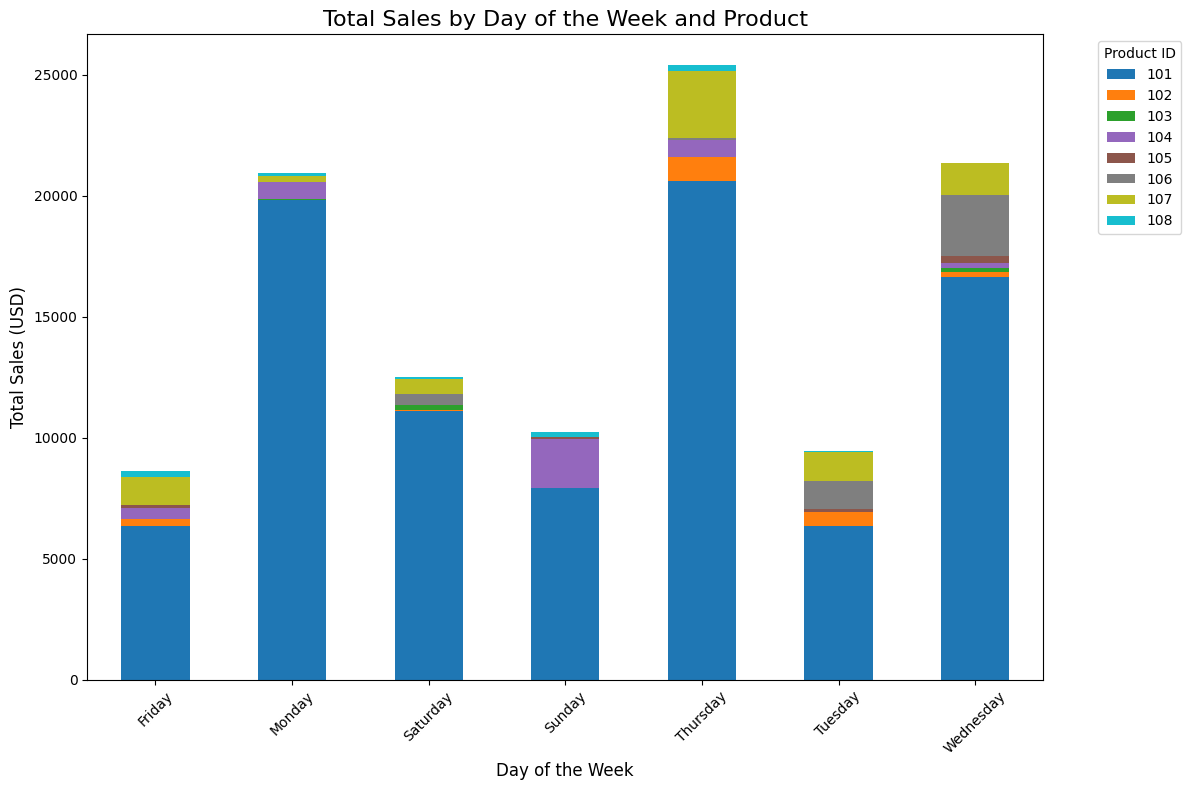

2025-04-17 22:13:16.053 | INFO     | __main__:main:94 - Analysis and visualization completed successfully.


In [15]:
# For local imports
PROJECT_ROOT = pathlib.Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from utils.logger import logger  # noqa: E402

# Constants
OLAP_OUTPUT_DIR: pathlib.Path = pathlib.Path("data").joinpath("olap_cubing_outputs")
CUBED_FILE: pathlib.Path = OLAP_OUTPUT_DIR.joinpath("multidimensional_olap_cube.csv")
RESULTS_OUTPUT_DIR: pathlib.Path = pathlib.Path("data").joinpath("results")

# Create output directory for results if it doesn't exist
RESULTS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def load_olap_cube(file_path: pathlib.Path) -> pd.DataFrame:
    """Load the precomputed OLAP cube data."""
    try:
        cube_df = pd.read_csv(file_path)
        logger.info(f"OLAP cube data successfully loaded from {file_path}.")
        return cube_df
    except Exception as e:
        logger.error(f"Error loading OLAP cube data: {e}")
        raise


def analyze_top_product_by_weekday(cube_df: pd.DataFrame) -> pd.DataFrame:
    """Identify the product with the highest revenue for each day of the week."""
    try:
        # Group by DayOfWeek and product_id, sum the sales
        grouped = cube_df.groupby(["DayOfWeek", "product_id"])["sale_amount_sum"].sum().reset_index()
        grouped.rename(columns={"sale_amount_sum": "TotalSales"}, inplace=True)

        # Sort within each day to find the top product
        top_products = grouped.sort_values(["DayOfWeek", "TotalSales"], ascending=[True, False]).groupby("DayOfWeek").head(1)
        logger.info("Top products identified for each day of the week.")
        return top_products
    except Exception as e:
        logger.error(f"Error analyzing top product by DayOfWeek: {e}")
        raise


def visualize_sales_by_weekday_and_product(cube_df: pd.DataFrame) -> None:
    """Visualize total sales by day of the week, broken down by product."""
    try:
        # Pivot the data to organize sales by DayOfWeek and ProductID
        sales_pivot = cube_df.pivot_table(
            index="DayOfWeek",
            columns="product_id",
            values="sale_amount_sum",
            aggfunc="sum",
            fill_value=0
        )

        # Plot the stacked bar chart
        sales_pivot.plot(
            kind="bar",
            stacked=True,
            figsize=(12, 8),
            colormap="tab10"
        )

        plt.title("Total Sales by Day of the Week and Product", fontsize=16)
        plt.xlabel("Day of the Week", fontsize=12)
        plt.ylabel("Total Sales (USD)", fontsize=12)
        plt.xticks(rotation=45)
        plt.legend(title="Product ID", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()

        # Save the visualization
        output_path = RESULTS_OUTPUT_DIR.joinpath("sales_by_day_and_product.png")
        plt.savefig(output_path)
        logger.info(f"Stacked bar chart saved to {output_path}.")
        plt.show()
    except Exception as e:
        logger.error(f"Error visualizing sales by day and product: {e}")
        raise


def main():
    """Main function for analyzing and visualizing top product sales by day of the week."""
    logger.info("Starting SALES_TOP_PRODUCT_BY_WEEKDAY analysis...")

    # Step 1: Load the precomputed OLAP cube
    cube_df = load_olap_cube(CUBED_FILE)

    # Step 2: Analyze top products by DayOfWeek
    top_products = analyze_top_product_by_weekday(cube_df)
    print(top_products)

    # Step 3: Visualize the results
    visualize_sales_by_weekday_and_product(cube_df)
    logger.info("Analysis and visualization completed successfully.")


if __name__ == "__main__":
    main()